In [1]:

# probability math function in python

from scipy.special import comb

import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1 - error)**(n_classifier-k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

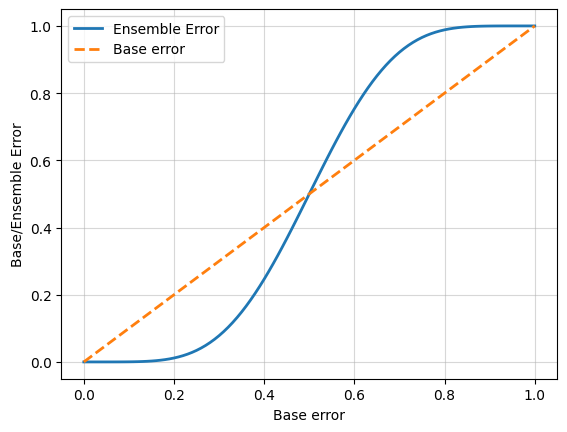

In [2]:
# ensemble error rates for different base errors 

import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)

ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble Error', linewidth=2)

plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [3]:
# weighted majority

import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [4]:
# weighteed majority vote based on class probabilities

ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [6]:

# import iris dataset and only use  two features and two labels

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# split into 50% training and test data

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=1, stratify=y)


In [8]:
# evaluate model performance via 10-fold cross validation before combining with ensemble classifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score( estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')

    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [9]:
# Combine individual classifiers for majority rule voting with our class
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')

    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')
    

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


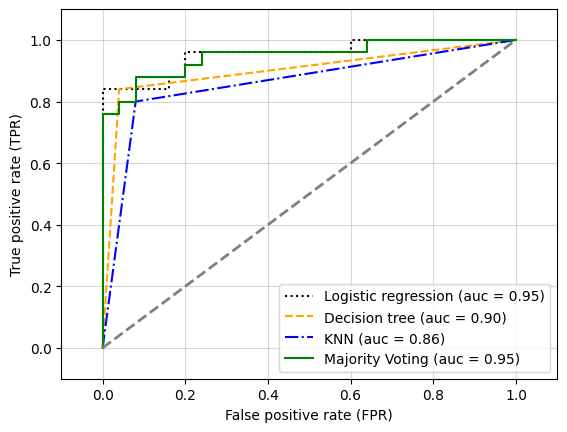

In [10]:
# Compute ROC curve from the test dataset to check how well it does with unseen data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']

linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)

    roc_auc = auc(x=fpr, y=tpr)

    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

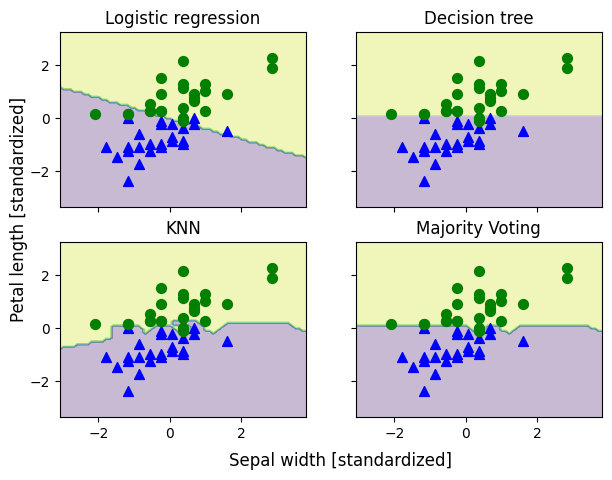

In [11]:
# standardize training set so decision regions of decision tree on same scale for viz purposes

sc = StandardScaler()

X_train_std = sc.fit_transform( X_train )
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid( np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip( product([0, 1], [0, 1]), all_clf, clf_labels):

    clf.fit( X_train_std, y_train )

    Z = clf.predict( np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf( xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c='green', 
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text( -3.5, -5., s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text( -12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)

plt.show()

In [12]:
# call get_params to access individual parameters of GridSearchCV

mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [13]:
# tune inverse regularization parameter, C

from sklearn.model_selection import GridSearchCV

params = { 'decisiontreeclassifier__max_depth': [1, 2],
           'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV( estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')

grid.fit( X_train, y_train )

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [14]:
# print hyperparameter combos and average ROC AUC

for r , _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC : {grid.best_score_:.2f}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC : 0.98


In [15]:
# preprocess wine data to use bagging (bootstrap aggregation)
# Use only 2 features and 2 classes
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [16]:
# encode labels into binary formetand split test/training data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [17]:
# use bagging classifier from sklearn
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

bag = BaggingClassifier( tree ,n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [18]:
# calculate accuracy score of prediction on train/test data 

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict( X_train )
y_test_pred = tree.predict( X_test )

tree_train = accuracy_score( y_train, y_train_pred )
tree_test = accuracy_score( y_test, y_test_pred )

print(f'Decision tree train/test accuracies {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


In [19]:
# bagging accuracies

bag = bag.fit( X_train, y_train )

y_train_pred = bag.predict( X_train )
y_test_pred = bag.predict( X_test )

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score( y_test, y_test_pred )

print(f'Bagging train/test accuracies {bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


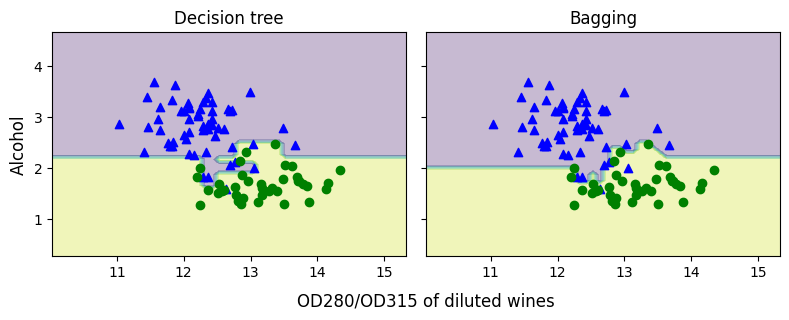

In [20]:
# compare decision regions between decision tree and bagging classifier

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):

    clf.fit( X_train, y_train )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='green', marker='o')
    
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()

plt.text(0, -0.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)

plt.show()

## ADABoost

In [21]:
# compute weighted error, epsilon

y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])

correct = (y == yhat)

weights = np.full(10, 0.1)

print(weights)

epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [22]:
# calculate alpha coefficient

alpha_j = 0.5 * np.log((1 - epsilon) / epsilon)

print(alpha_j)

0.42364893019360184


In [23]:
# update weight vector

update_if_correct = 0.1 * np.exp( -alpha_j * 1 * 1)

print(update_if_correct)

0.06546536707079771


In [24]:
# increase i-th weight of predicted label is incorrect

update_if_wrong_1 = 0.1 * np.exp( -alpha_j * 1 * -1)

print( update_if_wrong_1 )

0.1527525231651947


In [25]:
# update the weights

weights = np.where( correct == 1, update_if_correct, update_if_wrong_1)

print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [26]:
# normalize weights so they sum up to 1

normalized_weights = weights / np.sum( weights )
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


In [27]:
# Use adaboost in sklearn to train on wine data

from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier( criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(tree, n_estimators=500, learning_rate=0.1, random_state=1)

tree = tree.fit( X_train, y_train )

y_train_pred = tree.predict( X_train )
y_test_pred = tree.predict( X_test )

tree_train = accuracy_score( y_train, y_train_pred )
tree_test = accuracy_score( y_test, y_test_pred )

print(f'Decision tree train/test accuracies {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 0.916/0.875


In [28]:
ada = ada.fit(X_train, y_train )

y_train_pred = ada.predict( X_train )
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print(f'AdaBoost train/test accuracies {ada_train:.3f}/{ada_test:.3f}')

c:\Users\Andrew Solis\Projects\machine-learning-book\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost train/test accuracies 1.000/0.917


c:\Users\Andrew Solis\Projects\machine-learning-book\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


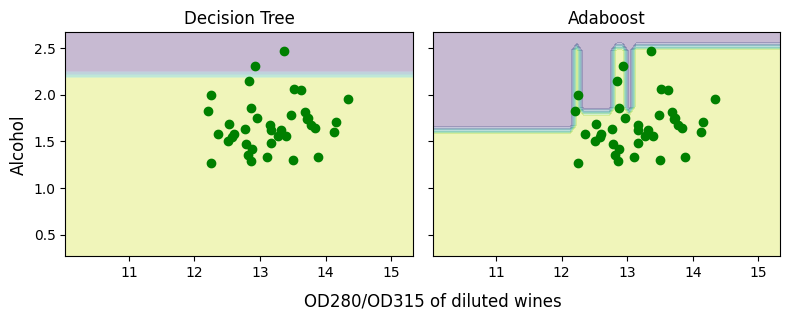

In [29]:
# display decision regions

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() - 1

xx, yy = np.meshgrid( np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots( 1, 2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'Adaboost']):

    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcohol', fontsize=12)
    
plt.tight_layout()
plt.text(0, -0.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)
plt.show()